In [22]:
import numpy as np
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from uncertainties import unumpy as unp
from uncertainties import ufloat, umath
from glob import glob
import tifffile
from options import *
from constants import *

nom_vals = unp.nominal_values
std_devs = unp.std_devs

mpl.rcParams.update(rcParams)



In [23]:
p = plt.rcParams
p['axes.grid'] = False
p['xtick.bottom'] = False
p['xtick.labelbottom'] = False
p['ytick.left'] = False
p['ytick.labelleft'] = False

In [24]:
wavelengths = [647, 561, 488]  # nm

In [25]:
def gaussian_2D(xy, amplitude, offset, mu_x, mu_y, sigma):
    x, y = xy
    res = amplitude * np.exp(-((x - mu_x)**2 + (y - mu_y)**2) / (2 * sigma**2)) + offset
    return np.ravel(res)

In [26]:
def do_fit(selection):
    XX = np.arange(selection.shape[0])
    YY = np.arange(selection.shape[1])
    XY = np.meshgrid(XX, YY)
    popt, pcov = sc.optimize.curve_fit(
        gaussian_2D,
        XY, selection.flatten(),
        p0=(1, 0, selection.shape[0] / 2, selection.shape[1] / 2, 1),
        bounds=(0, np.inf)
    )
    return popt, pcov

In [27]:
imdata = tifffile.imread('../data/beads/Acquisition-1/ROI.tif')
pix_min = np.min(imdata, axis=(1,2))
pix_max = np.max(imdata, axis=(1,2))
normalized_imdata = (imdata - pix_min[:, np.newaxis, np.newaxis]) / (pix_max - pix_min)[:, np.newaxis, np.newaxis]

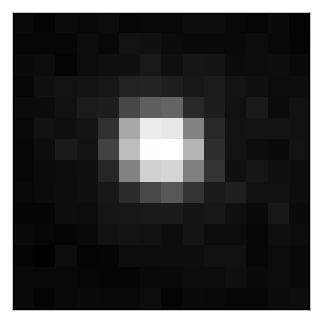

In [28]:
bead_sel = [slice(140, 154), slice(210, 224)]
plt.imshow(normalized_imdata[0, *bead_sel], cmap=plt.get_cmap('Greys_r'))

In [29]:
mu_xs = np.zeros(normalized_imdata.shape[0])
mu_ys = np.zeros(normalized_imdata.shape[0])
sigmas = np.zeros(normalized_imdata.shape[0])
for i, img in enumerate(normalized_imdata):
    popt, pcov = do_fit(img[*bead_sel])
    mu_xs[i] = popt[2]
    mu_ys[i] = popt[3]
    sigmas[i] = popt[4]

Text(0, 0.5, '$N$')

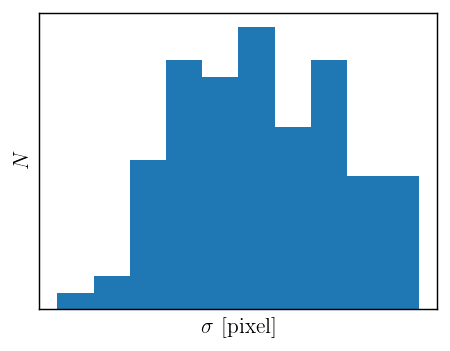

In [30]:
plt.hist(sigmas)
plt.xlabel(r"$\sigma$ [pixel]")
plt.ylabel(r"$N$")

Text(0, 0.5, '$N$')

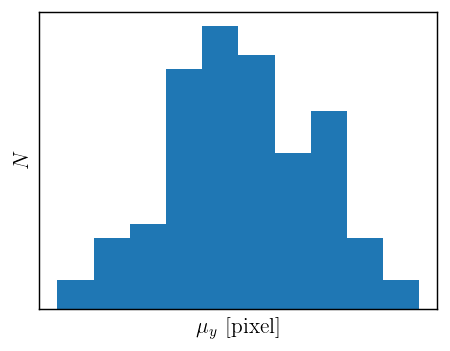

In [31]:
plt.hist(mu_ys)
plt.xlabel(r"$\mu_y$ [pixel]")
plt.ylabel(r"$N$")

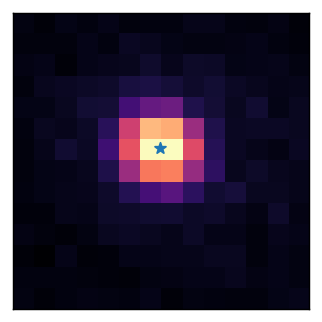

In [32]:
plt.imshow(normalized_imdata[0, *bead_sel], cmap=plt.get_cmap('magma'))
plt.scatter(np.mean(mu_xs), np.mean(mu_ys), marker='*', s=40)

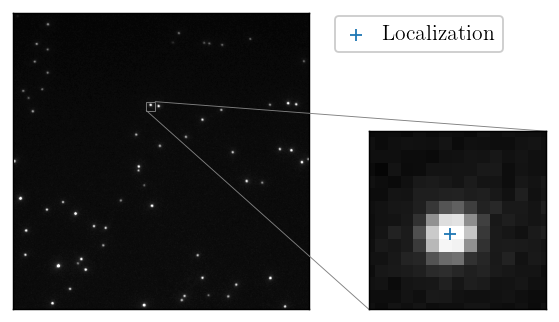

In [48]:
fig, ax = plt.subplots()
plt.xticks([])
plt.yticks([])

plt.imshow(normalized_imdata[0,:,:], cmap='Greys_r',
           vmax=0.4)

axins = ax.inset_axes([1,0,1,0.6], xlim=(210,224), ylim=(140, 154), alpha=0.5)
rect, connection_lines = ax.indicate_inset_zoom(axins, edgecolor="grey", alpha=1, lw=0.5)
plt.setp(connection_lines, lw=0.5)
# connection_lines[0].set_visible(True)
# connection_lines[1].set_visible(True)
# connection_lines[2].set_visible(True)
# connection_lines[3].set_visible(True)

axins.imshow(normalized_imdata[0], cmap=plt.get_cmap('Greys_r'),
            vmax=0.4)
axins.scatter(np.mean(mu_xs+210), np.mean(mu_ys+140), marker='+', s=40,
              label='Localization')

handles, labels = axins.get_legend_handles_labels()

fig.legend(handles=handles, labels=labels, bbox_to_anchor=(1.2, 0.9))
plt.savefig("../figures/beads_inset_zoom.pdf")
plt.show()

In [34]:
# plt.imshow(img[*bead_sel], cmap=plt.get_cmap('Greys_r'))

In [35]:
# ax = plt.subplot(projection='3d')
# ax.plot_surface(*XY, selected)